<a href="https://colab.research.google.com/github/Calebcarp/CS290/blob/main/kmean_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [45]:
iris = load_iris()

In [46]:
df = pd.DataFrame( iris.data, columns = iris.feature_names)

In [47]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [48]:
def kmeans(X, k, max_iters=100, initial_method='random', initial_centroids=None): # Initialize centroids based on the specified initialization method
    if initial_method == 'kmeans++':
        centroids = kmeans_plus_plus(X, k)
    elif initial_method == 'random': # Randomly select k initial centroids from the dataset X
        centroids = X[np.random.choice(X.shape[0], k, replace=False)] # X.shape gives the number of rows in X; replace=false means that once an element is chosen it cannot be chosen again
    elif initial_method == 'manual' and initial_centroids is not None: # If the 'manual' method is selected and initial centroids are provided use them
        centroids = np.array(initial_centroids)
    else: # Raise an error if an invalid initialization method is provided or initial centroids are missing
        raise ValueError("Invalid initialization method or missing initial centroids.")
    centroids_history = [] # List to keep track of centroids at each iteration
    for i in range(max_iters): # Iterate through the clustering process, up to max_iters times
        labels = np.array([np.argmin([euclidean_distance(point, c) for c in centroids]) for point in X]) # Assign each point in X to the nearest centroid
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)]) # Compute new centroids by taking the mean of all points assigned to each centroid
        centroids_history.append(new_centroids) # Append the new centroids to history
        if np.all(centroids == new_centroids): # Check if the centroids have converged
            print(f"Converged at iteration {i + 1}")
            break
        centroids = new_centroids # Update centroids for the next iteration
    return centroids, labels, centroids_history


In [49]:
def calculate_inertia(X, centroids, labels):
    inertia = 0 # Initialize inertia to 0. This will store the total sum of squared distances
    for i in range(len(centroids)): # Loop through each cluster (from 0 to k-1, where k is the number of centroids)
        points_in_cluster = X[labels == i] # Select all the points that belong to the current cluster
        inertia += np.sum((points_in_cluster - centroids[i]) ** 2) # Calculate the squared distance between each point in the cluster and the centroid of that cluster
    return inertia

In [50]:
def calculate_silhouette(X, labels):
    n_samples = X.shape[0] # Get the number of samples (data points) in X.
    silhouette_scores = [] # List to store the silhouette score for each sample.
    for i in range(n_samples):  # Iterate through each sample in the dataset.
        a_i = np.mean(np.linalg.norm(X[i] - X[labels == labels[i]], axis=1))
        # Compute a_i: The average distance from point X[i] to all other points in the same cluster.
        # X[labels == labels[i]] selects all points in the same cluster as X[i].
        # np.linalg.norm computes the Euclidean distance between X[i] and each point in the same cluster.
        # np.mean takes the average of those distances.
        b_i = np.min(np.mean(np.linalg.norm(X[i] - X[labels != labels[i]], axis=1)))
        # Compute b_i: The smallest average distance from point X[i] to all points in a different cluster.
        # X[labels != labels[i]] selects all points that do not belong to the same cluster as X[i].
        # Again, np.linalg.norm calculates the Euclidean distance, and np.mean computes the average distance.
        # np.min takes the minimum of these average distances
        silhouette_scores.append((b_i - a_i) / max(a_i, b_i))
        # Compute the silhouette score for the current sample:
        # (b_i - a_i) is the difference between the closest cluster's average distance (b_i)
        # and the average distance within the same cluster (a_i).
        # The silhouette score is calculated by dividing this difference by the maximum of a_i and b_i.
    return np.mean(silhouette_scores)

In [51]:
def kmeans_plus_plus(X, k):
    centroids = [X[np.random.choice(X.shape[0])]] # Randomly select a point from the dataset X and initialize it as the first centroid.
    for _ in range(1, k): # Loop to select the remaining k-1 centroids.
        distances = np.array([min([euclidean_distance(x, c) ** 2 for c in centroids]) for x in X])
        # `distances` is an array where each element is the squared distance from a point x to its nearest centroid.
        # This step computes the squared Euclidean distance for each data point x to each of the centroids already chosen.
        # The `min` function ensures that for each point, we take the distance to the closest centroid.
        prob_dist = distances / distances.sum()
        # Normalize the distances to create a probability distribution (prob_dist).
        # Each distance is divided by the sum of all distances to ensure probabilities sum to 1.
        cumulative_prob = np.cumsum(prob_dist) # Create a cumulative sum of the probabilities.
        rand_val = np.random.rand() # Generate a random value between 0 and 1.
        new_centroid_idx = np.searchsorted(cumulative_prob, rand_val)
        # Find the index of the new centroid by searching for the smallest value in cumulative_prob that is >= rand_val.
        # np.searchsorted finds the index where rand_val fits in the cumulative distribution.
        centroids.append(X[new_centroid_idx]) # Add the new centroid (the point at the index new_centroid_idx) to the centroids list.

    return np.array(centroids)

In [52]:
def calculate_cluster_purity(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)  # Create a confusion matrix
    purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)  # Sum of the max values in each column (most common true label in each cluster)
    return purity

In [53]:
X = df.values
true_labels = iris.target
centroids, labels, centroids_history = kmeans(X, k=3)
#centroids, labels, centroids_history = kmeans(X, k=3, initial_method= 'kmeans++')

Converged at iteration 5


In [54]:
inertia = calculate_inertia(X, centroids, labels)
print(f"Inertia: {inertia}")
silhouette = calculate_silhouette(X, labels)
print(f"Silhouette Score: {silhouette}")

Inertia: 142.75352002164502
Silhouette Score: 0.6899687785996493


In [55]:
purity = calculate_cluster_purity(true_labels, labels)
print(f"Cluster Purity: {purity:.4f}")

Cluster Purity: 0.6667


In [ ]:
def plot_kmeans_iterations(X, centroids_history, labels):
    n_iterations = len(centroids_history)
    for i in range(n_iterations):
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.7)
        centroids = centroids_history[i]
        ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, c='red', label='Centroids')
        ax.set_title(f'Iteration {i + 1}')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.legend()
        plt.show()

In [ ]:
def plot_silhouette_score_vs_k(X, k_values):
    silhouette_scores = []
    for k in k_values:
        centroids, labels, _ = kmeans(X, k=k)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
    plt.figure(figsize=(8, 3))
    plt.plot(k_values, silhouette_scores, "bo-")
    plt.xlabel("$k$ (Number of Clusters)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score vs k")
    plt.grid(True)
    plt.show()


In [ ]:
def plot_silhouette_coefficients(X, k_values):
    n_plots = len(k_values)
    plt.figure(figsize=(11, 9))
    for idx, k in enumerate(k_values):
        centroids, labels, _ = kmeans(X, k=k)
        silhouette_coefficients = silhouette_samples(X, labels)
        plt.subplot(2, (n_plots + 1) // 2, idx + 1)
        padding = len(X) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[labels == i]
            coeffs.sort()
            color = plt.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding
        plt.yticks(ticks, range(k))

        if k in (3, 5):
            plt.ylabel("Cluster")
        if k in (5, 6):
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=False)
        avg_score = silhouette_score(X, labels)
        plt.axvline(x=avg_score, color="red", linestyle="--")
        plt.title(f"$k={k}$")
    plt.tight_layout()
    plt.show()

Converged at iteration 2
Converged at iteration 4
Converged at iteration 6
Converged at iteration 11
Converged at iteration 14
Converged at iteration 5
Converged at iteration 12
Converged at iteration 8
Converged at iteration 6
Converged at iteration 9


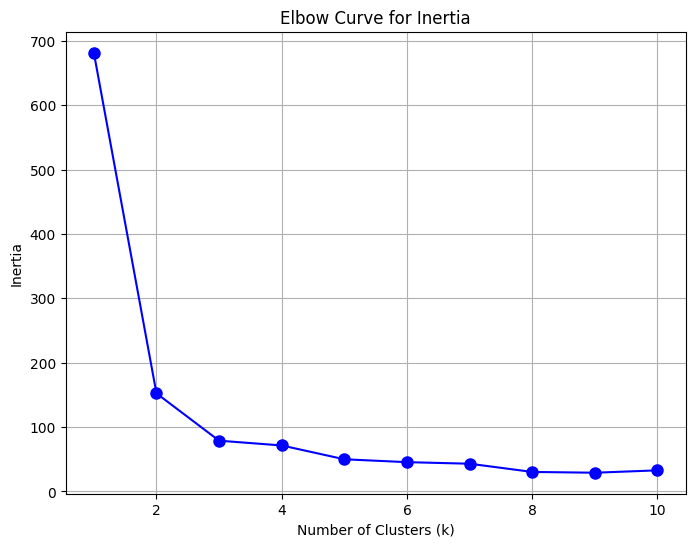

In [57]:
def plot_elbow_curve(X, k_values):
    inertias = []
    for k in k_values:
        centroids, labels, _ = kmeans(X, k=k)
        inertia = calculate_inertia(X, centroids, labels)
        inertias.append(inertia)
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, inertias, 'bo-', markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Curve for Inertia')
    plt.grid(True)
    plt.show()
k_values = range(1, 11)
plot_elbow_curve(X, k_values)

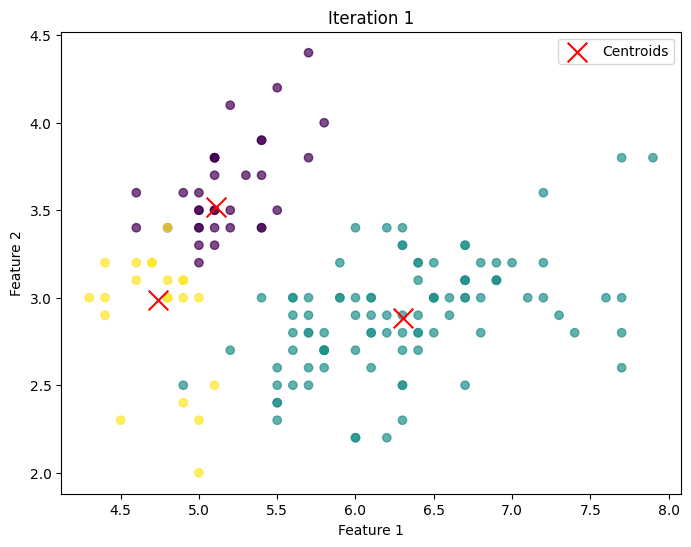

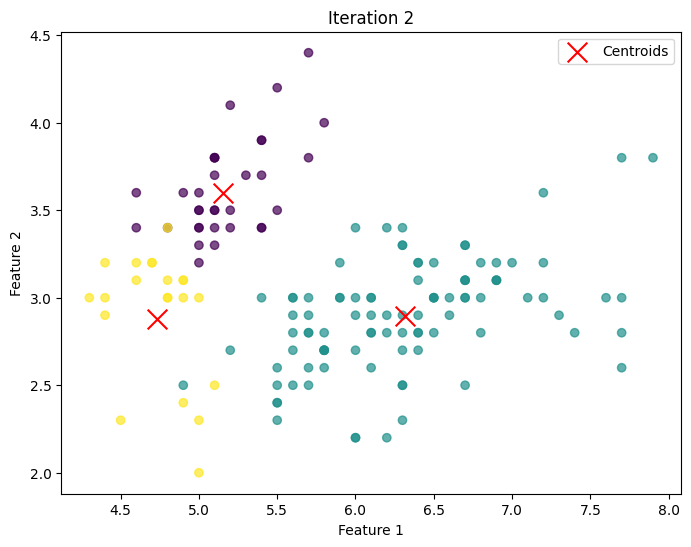

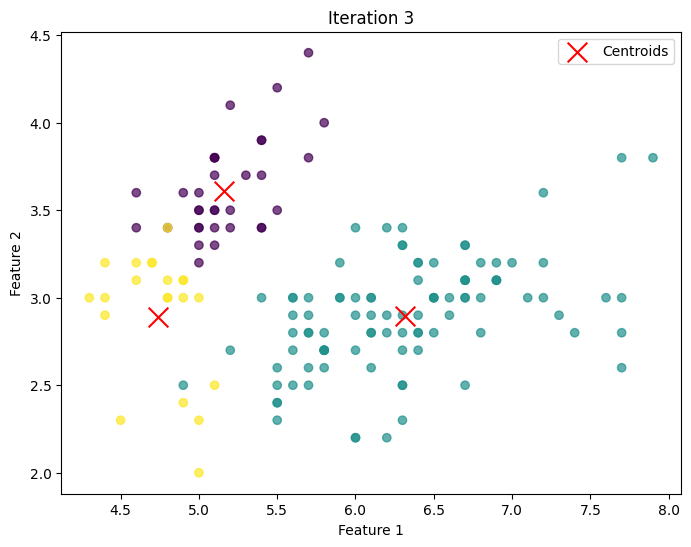

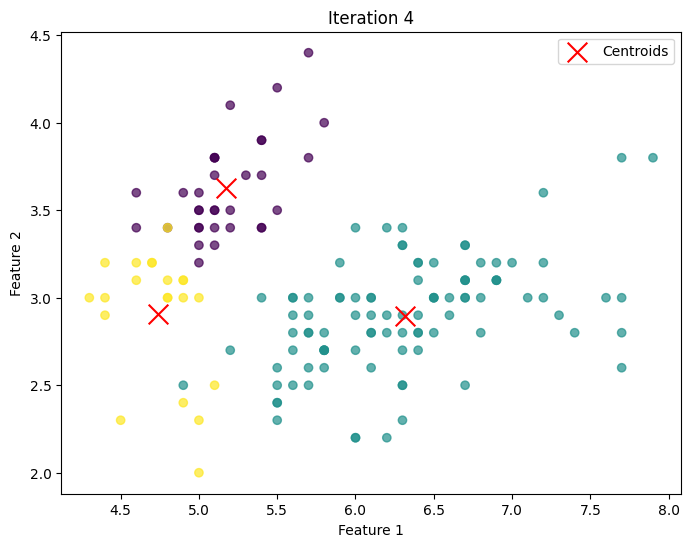

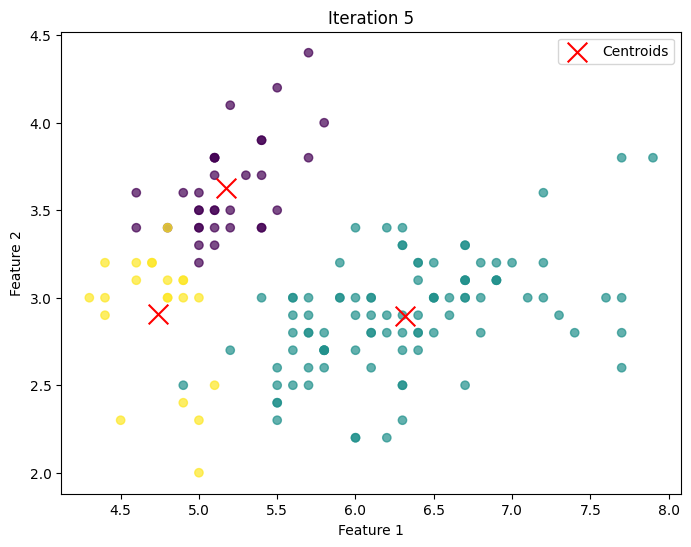

In [ ]:
plot_kmeans_iterations(X, centroids_history, labels)

Converged at iteration 5
Converged at iteration 8
Converged at iteration 9
Converged at iteration 6
Converged at iteration 13
Converged at iteration 9
Converged at iteration 10
Converged at iteration 8


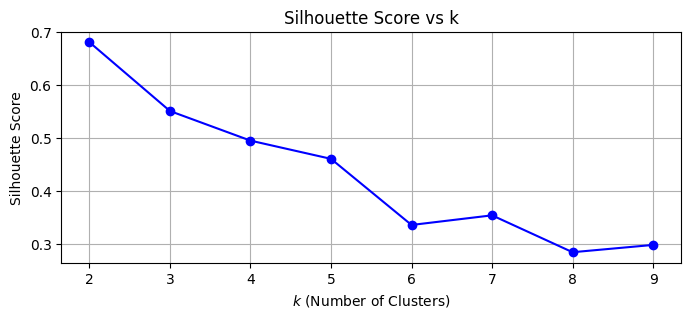

Converged at iteration 14
Converged at iteration 7
Converged at iteration 13
Converged at iteration 9


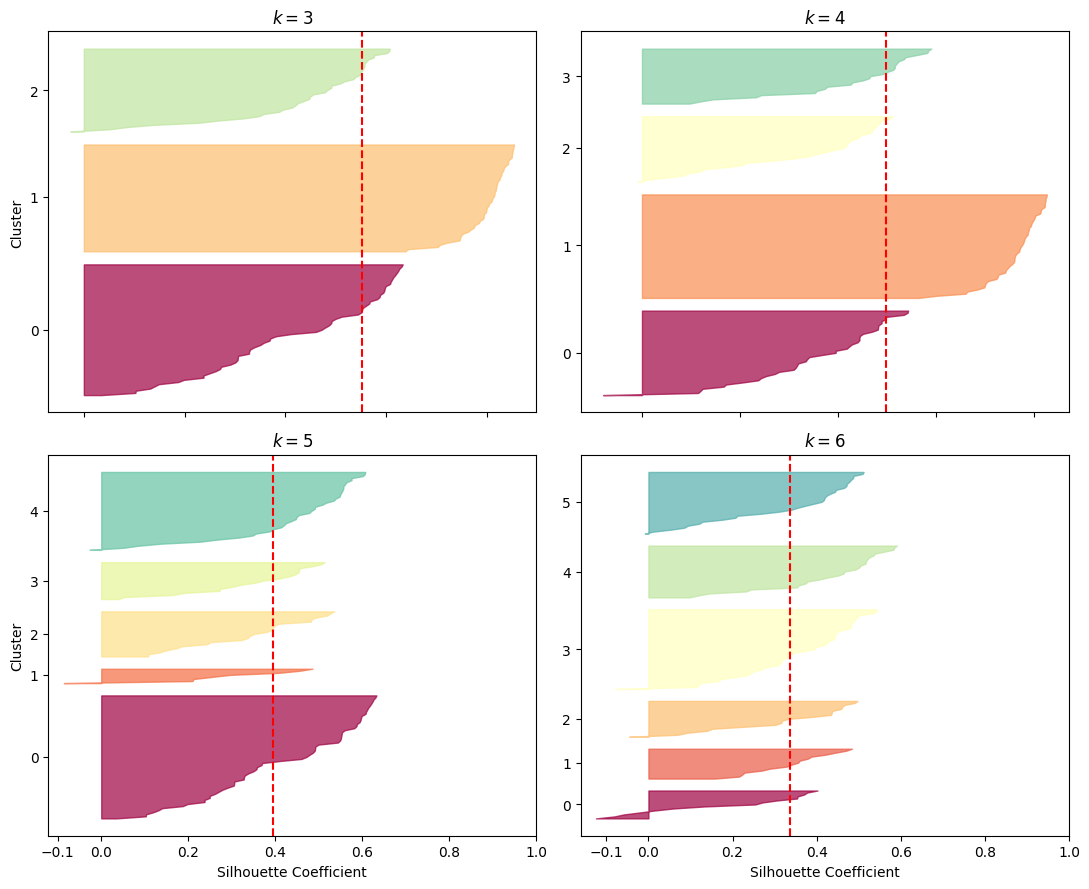

In [ ]:
k_values_for_score_plot = range(2, 10)
plot_silhouette_score_vs_k(X, k_values_for_score_plot)
k_values_for_coeff_plot = [3, 4, 5, 6]
plot_silhouette_coefficients(X, k_values_for_coeff_plot)